In [272]:
# Initialize Otter
import otter
grader = otter.Notebook("ProjPart2.ipynb")

# Project - Part 2: Predicting Housing Prices in Cook County

## Due Date: Thursday, April 25th, 11:59 PM MT on Gradescope

## NO LATE SUBMISSIONS will be accepted - you must plan accordingly.

## Collaboration Policy

Data science is a collaborative activity.  However a key step in learning and retention is **creating solutions on your own.**  

Below are examples of acceptable vs unacceptable use of resources and collaboration when doing the Project assignments in CSCI 3022.


The following would be some **examples of cheating** when working on the Project in CSCI 3022.  Any of these constitute a **violation of the course's collaboration policy and will result in an F in the course and a trip to the honor council**.   


 - Consulting web pages that may have a solution to a given homework problem or one similar is cheating.  However, consulting the class notes, and web pages that explain the material taught in class but do NOT show a solution to the homework problem in question are permissible to view.  Clearly, there's a fuzzy line here between a valid use of resources and cheating. To avoid this line, one should merely consult the course notes, the course textbook, and references that contain syntax and/or formulas.
 - Copying a segment of code or math solution of three lines or more from another student from a printout, handwritten copy, or by looking at their computer screen 
 - Allowing another student to copy a segment of your code or math solution of three lines or more
 - Taking a copy of another student's work (or a solution found online) and then editing that copy
 - Reading someone else’s solution to a problem on the Project before writing your own.
 - Asking someone to write all or part of a program or solution for you.
 - Asking someone else for the code necessary to fix the error for you, other than for simple syntactical errors
 


On the other hand, the following are some **examples of things which would NOT usually be
considered to be cheating**:
 - Working on a Project problem on your own first and then discussing with a classmate a particular part in the problem solution where you are stuck.  After clarifying any questions you should then continue to write your solution independently.
 - Asking someone (or searching online) how a particular construct in the language works.
 - Asking someone (or searching online) how to formulate a particular construct in the language.
 - Asking someone for help in finding an error in your program.  
 - Asking someone why a particular construct does not work as you expected in a given program.
   

To test whether you are truly doing your own work and retaining what you've learned you should be able to easily reproduce from scratch and explain a Project solution that was your own when asked in office hours by a TA/Instructor or on a quiz/exam.   


If you have difficulty in formulating the general solution to a problem on your own, or
you have difficulty in translating that general solution into a program, it is advisable to see
your instructor or teaching assistant rather than another student as this situation can easily
lead to a, possibly inadvertent, cheating situation.

We are here to help!  Visit HW Hours and/or post questions on Piazza!


## Introduction

In Part 1 of this project, you performed some basic exploratory data analysis (EDA), laying out the thought process that leads to certain modeling decisions. Then, you added a few new features to the dataset, cleaning the data as well in the process.

In Part 2 of the project, you will specify and fit a linear model to a few features of the housing data to predict housing prices. Next, we will analyze the error of the model and brainstorm ways to improve the model's performance. Finally, we'll delve deeper into the implications of predictive modeling within the Cook County Assessor's Office (CCAO) case study, especially because statistical modeling is how the CCAO valuates properties. Given the history of racial discrimination in housing policy and property taxation in Cook County, consider the impacts of your modeling results as you work through this assignment - and think about what fairness might mean to property owners in Cook County.

After this part of the project, you should be comfortable with:
- Implementing a data processing pipeline using `pandas`
- Using `scikit-learn` to build and fit linear models

## Score Breakdown

Question | Manual | Points
----|----|----
1abd | Yes | 8
1c | No | 1
2a | Yes | 3
2b | No | 1
3 | No | 8
4 | No | 11
5 | Yes | 14
6 | Yes | 4
Total | | 50 | 32
Extra Credit| Yes| Up to +20

In [273]:
import hashlib

import numpy as np

import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model as lm
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

from ds100_utils import run_linear_regression_test

def get_hash(num):
    return hashlib.md5(str(num).encode()).hexdigest()

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

Let's load the training and test data.

In [274]:
# RUN THIS  - DON'T COMMENT THIS OUT - it is needed for the autograder.

with zipfile.ZipFile('cook_county_data.zip') as item:
    item.extractall()

This dataset is split into a training/validation set and a testing set. Importantly, the test set does not contain values for our target variable, `Sale Price`. In this project, you will train a model on the training/validation set then use this model to predict the `Sale Price`s of the test set. In the cell below, we load the training/validation set into the `DataFrame` `training_val_data` and the test set into the `DataFrame` `test_data`.

In [275]:
training_val_data = pd.read_csv("cook_county_train_val.csv", index_col='Unnamed: 0')
test_data = pd.read_csv("cook_county_contest_test.csv", index_col='Unnamed: 0')

As a good sanity check, we should at least verify that the data shape matches the description.

In [276]:
# 204792 observations and 62 features in training data
assert training_val_data.shape == (204792, 62)
# 55311 observations and 61 features in test data
assert test_data.shape == (55311, 61)
# Sale Price is provided in the training/validation data
assert 'Sale Price' in training_val_data.columns.values
# Sale Price is hidden in the test data
assert 'Sale Price' not in test_data.columns.values

Let's remind ourselves of the data available to us in the Cook County dataset. Remember, a more detailed description of each variable is included in `codebook.txt`, which is in the same directory as this notebook). **If you did not attempt Project Part 1,** you should take some time to familiarize yourself with the codebook before moving forward.

In [277]:
training_val_data.columns.values

array(['PIN', 'Property Class', 'Neighborhood Code', 'Land Square Feet',
       'Town Code', 'Apartments', 'Wall Material', 'Roof Material',
       'Basement', 'Basement Finish', 'Central Heating', 'Other Heating',
       'Central Air', 'Fireplaces', 'Attic Type', 'Attic Finish',
       'Design Plan', 'Cathedral Ceiling', 'Construction Quality',
       'Site Desirability', 'Garage 1 Size', 'Garage 1 Material',
       'Garage 1 Attachment', 'Garage 1 Area', 'Garage 2 Size',
       'Garage 2 Material', 'Garage 2 Attachment', 'Garage 2 Area',
       'Porch', 'Other Improvements', 'Building Square Feet',
       'Repair Condition', 'Multi Code', 'Number of Commercial Units',
       'Estimate (Land)', 'Estimate (Building)', 'Deed No.', 'Sale Price',
       'Longitude', 'Latitude', 'Census Tract',
       'Multi Property Indicator', 'Modeling Group', 'Age', 'Use',
       "O'Hare Noise", 'Floodplain', 'Road Proximity', 'Sale Year',
       'Sale Quarter', 'Sale Half-Year', 'Sale Quarter of Year'

<br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Question 1: Human Context and Ethics

In this part of the project, we will explore the human context of our housing dataset.

**You should read the [Project_CaseStudy.pdf](https://canvas.colorado.edu/courses/101142/files/73347502?module_item_id=5144290) on Canvas explaining the context and history surrounding this dataset before attempting this section.**

<br>

--- 

<!-- BEGIN QUESTION -->

### Question 1a
"How much is a house worth?" Who might be interested in an answer to this question? **Please list at least three different parties (people or organizations) and state whether each one has an interest in seeing the housing price to be high or low.**

- Property investment/investment companies, who would want the price to be high if selling, and low if buying. They'll also probably be interested to know if the area is developing.
- House buyers, who would want the price to be low and within their budget.
- The government, who might have an interest in seeing the housing prices high to increase property tax revenue.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 1b

Which of the following scenarios strike you as unfair and why? You can choose more than one. There is no single right answer, but you must explain your reasoning. Would you consider some of these scenarios more (or less) fair than others? Why?

A. A homeowner whose home is assessed at a higher price than it would sell for.  
B. A homeowner whose home is assessed at a lower price than it would sell for.  
C. An assessment process that systematically overvalues inexpensive properties and undervalues expensive properties.  
D. An assessment process that systematically undervalues inexpensive properties and overvalues expensive properties.


All of the scenarios are unfair.

A, is unfair because it means the homeowner is paying more in property tax than they should be. Also would give the homeowner false hope that their home has appreciated more than it actually did

B, because if my home was assessed at a lower valuation than it should be, it means im not getting as big of a return on my investment which means I lose money. Selling at a loss (compared to market value) is like doing charity. You would pay less in property tax though.

C, is very unfair because it would mean that the people who can afford expensive properties are getting a break, while the people who can't afford expensive properties are getting screwed. Lower income properties will be priced higher than they should be making them inaccessible.

D, is unfair because it does not accurately reflect the market value of the proprty. But because majority of the people are not rich and don't buy expensive properties, it shifts the burden of property tax to owner's of expensive properties who are more likely to be able to afford them. 

<!-- END QUESTION -->

---

### Question 1c

Consider a model that is fit to $n = 50$ training observations. We denote the response as $y$ (Log Sale Price), the prediction as $\hat{y}$, and the corresponding residual to be $y - \hat{y}$. Which residual plot corresponds to a model that might make property assessments that result in regressive taxation? (Refer to the [Project_CaseStudy.pdf](https://canvas.colorado.edu/courses/101142/files/73347502?module_item_id=5144290) for a reminder of the definition of regressive taxation).  Assume that all three plots use the same vertical scale and that the horizontal line marks $y - \hat{y} = 0$. Assign `q1c` to the string letter corresponding to your plot choice.

**Hint:** When a model overvalues a property (predicts a `Sale Price` greater than the actual `Sale Price`), what are the relative sizes of $y$ and $\hat{y}$? What about when a model undervalues a property?

<img src='res_plots.png' width="900px" />


In [278]:
q1c = 'A'

In [279]:
grader.check("q1c")

q1c results: All test cases passed!

## The CCAO Dataset

You'll work with the dataset from the Cook County Assessor's Office (CCAO) in Illinois. This government institution determines property taxes across most of Chicago's metropolitan areas and nearby suburbs. In the United States, all property owners must pay property taxes, which are then used to fund public services, including education, road maintenance, and sanitation. These property tax assessments are based on property values estimated using statistical models considering multiple factors, such as real estate value and construction cost.

This system, however, is not without flaws. In late 2017, a lawsuit was filed against the office of Cook County Assessor Joseph Berrios for producing "[racially discriminatory assessments and taxes](https://www.chicagotribune.com/politics/ct-cook-county-board-assessor-berrios-met-20170718-story.html)." The lawsuit included claims that the assessor's office undervalued high-priced homes and overvalued low-priced homes, creating a visible divide along racial lines: Wealthy homeowners, who were typically white, [paid less in property taxes](https://fix8media-chicago.squarespace.com/bpnc-v-berrios-resource-page), whereas [working-class, non-white homeowners paid more](https://www.chicagotribune.com/news/breaking/ct-cook-county-assessor-berrios-sued-met-20171214-story.html).

The Chicago Tribune's four-part series, "[The Tax Divide](https://www.chicagotribune.com/investigations/ct-tax-divide-investigation-20180425-storygallery.html)", delves into how this was uncovered: After "compiling and analyzing more than 100 million property tax records from the years 2003 through 2015, along with thousands of pages of documents, then vetting the findings with top experts in the field," they discovered that "residential assessments had been so far off the mark for so many years." You can read more about their investigation [here](https://apps.chicagotribune.com/news/watchdog/cook-county-property-tax-divide/assessments.html).

**You should read the [Project_CaseStudy.pdf](https://canvas.colorado.edu/courses/101142/files/73347502?module_item_id=5144290) explaining the history about this dataset before answering the following question.**

<!-- BEGIN QUESTION -->

### Question 1d

What were the central problems with the earlier property tax system in Cook County as reported by the Chicago Tribune ? And what were the primary causes of these problems? (Note: in addition to reading the paragraph above you will need to **read the [Project_CaseStudy.pdf](https://canvas.colorado.edu/courses/101142/files/73347502?module_item_id=5144290) explaining the context and history of this dataset  before answering this question).**

The central problems with the earlier property tax system in Cook County was that lower priced homes were being overvalued while higher priced homes were being undervalued. The primary cause to these problems were not to do with the models the county assessor's office was using but the appeal system that allowed wealthier homeowners with better legal representation to appeal their property assessments. Having more time, money and accessibility to better legal representation allowed wealthier homeowners challenge their property assesments more successfully. This system created a system which favored those with financial means and better legal representation.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Question 2a:  More EDA

<br>

In good news you have already done a lot of EDA with this dataset in Project 1. 

Before fitting any model, we should check for any missing data and/or unusual outliers.

Since we're trying to predict `Sale Price`, we'll start with that field.

Examine the `Sale Price` column in the `training_val_data` DataFrame and answer the following questions:


 - 2ai).  Does the `Sale Price` data have any missing, N/A, negative or 0 values for the data?  If so, propose a way to handle this.

 - 2aii).  Does the `Sale Price` data have any unusually large outlier values?  If so, propose a cutoff to use for throwing out large outliers, and justify your reasoning).  

 - 2aiii).  Does the `Sale Price` data have any unusually small outlier values?  If so, propose a cutoff to use for throwing out small outliers, and justify your reasoning.  
 
 
Below are three cells.  The first is a Markdown cell for you to write up your responses to all 3 parts above.
The second two are code cells that are available for you to write code to explore the outliers and/or visualize the Sale Price data.

### Question 2a i, ii, iii answer cell:**  

2ai) There are no 0 or null values in the dataset but there is an unproportional amount of houses with the price of 1. This might be a placeholder value for missing data. Searching online, it seems that $1 is a placeholder for non-market transactions such as transfers between family members (https://www.quora.com/What-does-it-mean-when-a-property-is-sold-for-1). I am not sure how accurate the source is but that's the most I can gather from this. I believe it would be reasonable to remove any Sale Prices that are less than $100 as they are likely to be a placeholder or unrepresentative of the actual value of the property (https://prodassets.cookcountyassessor.com/s3fs-public/reports/PCS_Cook-County_CSRS_v1.pdf)

2aii) Sale Price does have unusually large outlier values which are most likely just very expensive properties. To determine the cutoff, I propose using a cut off similar to the one I suggested in part 1 of this project. That is, we can overcome this issue is by only including houses within and slightly beyond the whiskers of the box-plot as that is where we can expect most of our house prices to be within. That is we should limit our Sale Price to only contain prices within $[4.52\cdot10^4 - (2\cdot (3.12\cdot10^5 - 4.52\cdot10^4)), 3.12\cdot10^5 + (2\cdot (3.12\cdot10^5 - 4.52\cdot10^4))]$ Because the calculation for the lower end will be negative, we can just set it to 0.

2aiii) Sale Price does have unusually small outlier values as I explained in 2ai. I propose using a cutoff of $100 as that is the cut off used by the cook county assessor's office (according to that pdf i found) for their own analysis and studies.

In [280]:
print(training_val_data['Sale Price'].describe())

# hmm the min of 1 is kind of suspicious but I'm going to check the number of null values first
print("Number of null values: ", training_val_data['Sale Price'].isnull().sum())

# Is the null values replaced with 1 in this dataset?
print("Number of sales with price 1: ", (training_val_data['Sale Price'] == 1).sum())

# Checking if it is actually normal for the prices of houses to be 1
print("Number of sales with price between 1 (exclusive) and 1000:", 
      ((training_val_data['Sale Price'] > 1) & (training_val_data['Sale Price'] <= 100)).sum())

print("Ratio of sales above 75% + 2 * IQR: ", 
      ((training_val_data['Sale Price'] > training_val_data['Sale Price'].quantile(0.75)
        + 2 * (training_val_data['Sale Price'].quantile(0.75) 
               - training_val_data['Sale Price'].quantile(0.25))).sum())
               /training_val_data.shape[0])

# hmm 6% of data being above the 75% + 1.5 * IQR is a bit high so i'll try 2 * IQR
print("75% + 2 * IQR: ", 
      training_val_data['Sale Price'].quantile(0.75) 
      + 2 * (training_val_data['Sale Price'].quantile(0.75) 
               - training_val_data['Sale Price'].quantile(0.25)))

# your code exploring Sale Price above this line

count    2.047920e+05
mean     2.451646e+05
std      3.628694e+05
min      1.000000e+00
25%      4.520000e+04
50%      1.750000e+05
75%      3.120000e+05
max      7.100000e+07
Name: Sale Price, dtype: float64
Number of null values:  0
Number of sales with price 1:  35546
Number of sales with price between 1 (exclusive) and 1000: 300
Ratio of sales above 75% + 2 * IQR:  0.04169108168287824
75% + 2 * IQR:  845600.0


<!-- END QUESTION -->

**Pure Market Filter**

As you (hopefully) noticed, there are quite a few small values for the Sale Price of a home that don't make sense.  This can happen when someone sells a house to a relative for $\$1$ or some other price that is not reflective of the true market value.  There are also several extremely large outliers (houses that sold for more than $10 million) that don't accurately capture the true market value of a home.

It turns out, there's actually an indicator feature already available in the dataset to help filter out any sale transactions that aren't considered "Pure Market Transactions"  (for example, when someone sells a house to a relative for $\$1$, we don't consider that a transaction driven by the true market value of the house.

We'll use this indicator feature in the next section to remove non-market transactions before fitting our models.


### Question 2b

What are the max and min Sale Price values for the subset of data in the training_val dataset with the indicator `Pure Market Filter` = 1?



In [281]:
max_Sale_Price_filtered = int(training_val_data[training_val_data['Pure Market Filter'] == 1]['Sale Price'].max())
min_Sale_Price_filtered = int(training_val_data[training_val_data['Pure Market Filter'] == 1]['Sale Price'].min())

print("Max Sale Price filtered: ", max_Sale_Price_filtered)
print("Min Sale Price filtered: ", min_Sale_Price_filtered)


Max Sale Price filtered:  8490078
Min Sale Price filtered:  10003


In [282]:
grader.check("q2d")

q2d results: All test cases passed!

<br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Question 3: Fitting a Simple Linear Regression Model

In Part 1 of the project, you plotted the log-transformed Sale Price vs the log-transformed total area covered by the building (in square feet)  and saw there was a positive linear association.  Let's start the modeling process by fitting a simple linear regression model using this predictor.  

Our first model will take the form:

$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Log Building Square Feet})
$$



<br>

--- 

### Question 3a:  Training/Validation Split


The data has already been split into a training_val set and a test set.  Let's further split the training_val set into a training set and a validation set. We will use the training set to fit our model's parameters and the validation set to evaluate how well our model will perform on unseen data drawn from the same distribution. If we used all the data to fit our model, we would not have a way to estimate model performance on **unseen data** such as the test set in `cook_county_contest_test.csv`.

In the cell below, complete the function `train_val_split` that splits an input DataFrame `data` into two smaller `DataFrame`s named `train` and `validation`,where  
`train` contains 80% of the data and `validation` contains the remaining 20%.  You should not be importing any additional libraries for this question. 
 

**Hint:**  When creating your validation and training sets, there is already code provided that uses the numpy method [permutation](https://numpy.org/doc/stable/reference/random/generated/numpy.random.permutation.html) to shuffle the indices of the dataframe (and save in an array called `shuffled_indices`).  You just need to write code to select the first 80% of the indices from `shuffled_indices` to use for selecting the training data and the last 20% of the indices to use when selecting the validation data.  Do not reorder the array `shuffled_indices` when creating the validation and training sets as we will be comparing your results later in the notebook and you need to have the same ordering of the data to pass the test cases.  


Then, use these arrays to index into `data` to create your final `train` and `validation` DataFrames. To ensure that your code matches our solution, use the first 80% as the training set and the last 20% as the validation set. Remember, the values you use to partition `data` must be integers!

*The provided tests use the same random seed to check that you not only answered correctly but ended up with the same train/validation split as our reference implementation. Later testing is easier this way.*

In [283]:

def train_val_split(data):
    """ 
    Takes in a DataFrame `data` and randomly splits it into two smaller DataFrames 
    named `train` and `validation` with 80% and 20% of the data, respectively. 
    """
    data_len = data.shape[0]
    shuffled_indices = np.random.permutation(data_len)
    
    split_idx = int(data_len * 0.8)
    train_idx = shuffled_indices[:split_idx]
    validation_idx = shuffled_indices[split_idx:]
    
    train = data.iloc[train_idx]
    validation = data.iloc[validation_idx]
   
    
    return train, validation

 
#This makes the train-test split in this section reproducible across different runs 
# of the notebook. DO NOT CHANGE THIS RANDOM SEED.
np.random.seed(1337)

train, valid = train_val_split(training_val_data)

print("Training data shape: ", train.shape)
print("Validation data shape: ", valid.shape)
print("Total data shape: ", training_val_data.shape)

Training data shape:  (163833, 62)
Validation data shape:  (40959, 62)
Total data shape:  (204792, 62)


In [284]:
grader.check("q3a")

q3a results: All test cases passed!

<br>

--- 
## Modeling Step 1:  Feature Transformation

<br>

## Create a pipeline to process the data

It is time to prepare the training and validation data for the model we proposed above. 

In Project Part 1, you wrote a few functions that added features to the dataset. Instead of calling them manually one by one each time, it is best practice to encapsulate all of this feature engineering into one "pipeline" function. Defining and using a pipeline reduces all the feature engineering to just one function call and ensures that the same transformations are applied to all data.  



For an example of how to work with pipelines, we have processed model 1 for you using `process_data_m1` in the below cell. 



In particular the cell below completes the following steps:

  1. Creates a function `process_data_m1` to perform the following feature engineering:  
     - Removes rows in the dataset that have the indicator `Pure Market Filter`= 0 (these are outliers that are not representative of sales driven by the true housing market).
     - Applies log transformations to the `Sale Price` and the `Building Square Feet` columns to create two new columns, `Log Sale Price` and `Log Building Square Feet`.
     - Selects the columns and `Log Sale Price` , `Log Building Square Feet`
     - Outputs the transformed DataFrame
 
 2. Run `process_data_m1` separately on the training data and then the validation data.  Then output the design matrix $\mathbb{X}$ and the observed vector $\mathbb{Y}$ for both the training data and the validation data (save them in the variable names `X_train_m1`, `Y_train_m1`, `X_valid_m1`, `Y_valid_m1`). Note that $\mathbb{Y}$ refers to the transformed `Log Sale Price`, not the original `Sale Price`. **Your design matrix should be a `pandas` DataFrame and your observed vector should be a `pandas` Series.**.


In [285]:
# Just Run This Cell.   Make sure you understand what each part is doing - you will use this format when you expand the model


def process_data_m1(data):
    """ 
    Takes in a DataFrame `data` and performs data transformations and processing to use for Model 1
    """
    
    # Remove outliers
    data = data[data["Pure Market Filter"]==1]
    
    # Create Log Sale Price column
    data["Log Sale Price"] = np.log(data["Sale Price"])
    
    # Create Log Building Square Feet column
    data["Log Building Square Feet"] = np.log(data["Building Square Feet"])
    
    # Select columns for the model
    data = data[['Log Building Square Feet', 'Log Sale Price']]
    
    return data



# Process both the training and validation data 
processed_train_m1 = process_data_m1(train)

processed_val_m1 = process_data_m1(valid)


# Create X (dataframe) and Y (series) to input into model
X_train_m1 = processed_train_m1.drop(columns = "Log Sale Price")
Y_train_m1 = processed_train_m1["Log Sale Price"]

X_valid_m1 = processed_val_m1.drop(columns = "Log Sale Price")
Y_valid_m1 = processed_val_m1["Log Sale Price"]

# Take a look at the result
display(X_train_m1.head())
display(Y_train_m1.head())

display(X_valid_m1.head())
display(Y_valid_m1.head())


Log Building Square Feet
130829                  7.870166
193890                  7.002156
30507                   6.851185
91308                   7.228388
131132                  7.990915

130829    12.994530
193890    11.848683
30507     11.813030
91308     13.060488
131132    12.516861
Name: Log Sale Price, dtype: float64

Log Building Square Feet
50636                   7.310550
82485                   7.325808
193966                  7.090077
160612                  7.281386
7028                    7.118016

50636     11.682668
82485     12.820655
193966     9.825526
160612    12.468437
7028      12.254863
Name: Log Sale Price, dtype: float64

## Modeling Step 2:  Create a linear model

Next we'll use `sci-kit learn` to train the model.



### Question 3b


We first initialize a [`sklearn.linear_model.LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) object for our model. 

We set the `fit_intercept = True` to ensure that the linear model has a non-zero intercept.


Fill in the rest of the code below to fit the model using the training set and then output predictions for both the training and validation set.  

In [286]:
linear_model_m1 = lm.LinearRegression(fit_intercept=True)

# Fit the model using the processed training data
linear_model_m1.fit(X_train_m1, Y_train_m1)

# Compute the predicted y values from linear model 1 (in units log sale price) using the training data and 
# again using the validation data:


Y_predict_train_m1 = linear_model_m1.predict(X_train_m1)

Y_predict_valid_m1 = linear_model_m1.predict(X_valid_m1)

# Outputting the predictions for training and validation data

print("Predictions for training data:")
# since X_train_m1 is a dataframe im going to add the preictions as a column
display(X_train_m1.assign(Predicted_Log_Sale_Price=Y_predict_train_m1))


print("Predictions for validation data:")
display(X_valid_m1.assign(Predicted_Log_Sale_Price=Y_predict_valid_m1))

Predictions for training data:


Log Building Square Feet  Predicted_Log_Sale_Price
130829                  7.870166                 12.961495
193890                  7.002156                 11.812737
30507                   6.851185                 11.612936
91308                   7.228388                 12.112142
131132                  7.990915                 13.121300
...                          ...                       ...
179808                  7.090077                 11.929095
27245                   7.539559                 12.523957
61752                   8.407155                 13.672168
33900                   7.301148                 12.208434
162935                  7.272398                 12.170386

[133849 rows x 2 columns]

Predictions for validation data:


Log Building Square Feet  Predicted_Log_Sale_Price
50636                   7.310550                 12.220878
82485                   7.325808                 12.241070
193966                  7.090077                 11.929095
160612                  7.281386                 12.182280
7028                    7.118016                 11.966071
...                          ...                       ...
71538                   7.818430                 12.893026
153946                  7.193686                 12.066215
117415                  7.255591                 12.148143
9448                    7.605890                 12.611742
188605                  6.802395                 11.548365

[33535 rows x 2 columns]

In [287]:
grader.check("q3b")

q3b results: All test cases passed!

<br>


## Modeling Step 3:  Model Evaluation Using RMSE


We'll compare the performance of our models using the Root Mean Squared Error (RMSE) function.

$$RMSE = \sqrt{\dfrac{\sum_{\text{houses in the set}}(\text{actual price for house} - \text{predicted price for house})^2}{\text{number of houses}}}$$


### QUESTION 3c:

Complete the code below for the funtion RMSE:

In [288]:
def rmse(predicted, actual):
    """
    Calculates RMSE from actual and predicted values
    Input:
      predicted (1D array): vector of predicted/fitted values
      actual (1D array): vector of actual values
    Output:
      a float, the root-mean square error
    """
    
    return np.sqrt(np.mean((predicted - actual)**2))

In [289]:
grader.check("q3c")

q3c results: All test cases passed!

### Keeping track of all the models.

In this notebook (and in life) we will want to keep track of all our models. 
For this part of the project you will be creating 3 different versions of the model.

In [290]:
# Just run this cell to create arrays to store the RMSE information from the models

model_names=["M1: log(bsqft)", "M2", "M3"]

# Create arrays where we can keep track of training and validation RMSE for each model

training_error_log = np.zeros(4)
validation_error_log = np.zeros(4)

training_error = np.zeros(4)
validation_error = np.zeros(4)

# Array to track cross validation errors average RMSE errors  

cv_error = np.zeros(4)


## QUESTION 3d:



In the cell below use your `rmse` function to calculate the training error and validation error for model 1.

Assign the RMSE of the predicted log sale prices and the actual log sale prices to the following variables: 

 `training_error_log[0]`  and    `validation_error_log[0]`


Since the target variable we are working with is log-transformed, it can also be beneficial to transform it back to its original form so we will have more context on how our model is performing when compared to actual housing prices.  In other words we want the RMSE **with regard to `Sale Price`**. Remember to exponentiate your predictions and response vectors before computing the RMSE using the `rmse` function and assign it to the following:

`training_error[0]` and    `validation_error[0]`



In [291]:
# Training and validation RMSE for the model (in units log sale price)

training_error_log[0] = rmse(Y_predict_train_m1, Y_train_m1)
validation_error_log[0]= rmse(Y_predict_valid_m1, Y_valid_m1)


# Training and validation RMSE for the model (in its original dollar values before the log transform)

training_error[0] = rmse(np.exp(Y_predict_train_m1), np.exp(Y_train_m1))
validation_error[0] = rmse(np.exp(Y_predict_valid_m1), np.exp(Y_valid_m1))


print("1st Model\nTraining RMSE (log): {}\nValidation RMSE (log): {}\n".format(training_error_log[0], validation_error_log[0]))
print("1st Model \nTraining RMSE: {}\nValidation RMSE: {}\n".format(training_error[0], validation_error[0]))


1st Model
Training RMSE (log): 0.7509790948543054
Validation RMSE (log): 0.7508998658616935

1st Model 
Training RMSE: 249895.90791759416
Validation RMSE: 255533.8404150553



In [292]:
grader.check("q3d")

q3d results: All test cases passed!

## Modeling Step 4: Cross Validation

To check that the validation RMSE is representative of the dataset we'll also perform a 5-fold cross validation on the model.

In [293]:
# Just run this cell.  It uses 5-fold cross validation to check that our validation errors weren't a fluke.
# Make sure you understand what this code is doing, you will need it again when you update the model.

from sklearn.model_selection import KFold
from sklearn.base import clone

def cross_validate_rmse(model, X, y):
    model = clone(model)
    five_fold = KFold(n_splits=5) 
    de_logged_rmse_values = []
    for tr_ind, va_ind in five_fold.split(X):
        model.fit(X.iloc[tr_ind,:], y.iloc[tr_ind])
        de_logged_rmse_values.append(rmse(np.exp(y.iloc[va_ind]), np.exp(model.predict(X.iloc[va_ind,:]))))
    return np.mean(de_logged_rmse_values)


# Create a new model to fit on the whole training_val dataset
linear_model_m1_cv = lm.LinearRegression(fit_intercept=True)


# Process the entire training_val dataset using the pipeline
processed_full_m1 = process_data_m1(training_val_data)


# Split into X and Y:
X_full_m1 = processed_full_m1.drop(columns = "Log Sale Price")
Y_full_m1 = processed_full_m1["Log Sale Price"]

# DO NOT CHANGE THIS LINE - it ensures reproducibility 
np.random.seed(1330)

# Run Cross Validation and Output RMSE (in units of Sale Price):
cv_error[0] = cross_validate_rmse(linear_model_m1_cv, X_full_m1, Y_full_m1)
print("1st Model Cross Validation RMSE: {}".format(cv_error[0]))

1st Model Cross Validation RMSE: 250986.19718987675


## Modeling Step 5: Visualizations

## Visualizing RMSE

In [294]:
# Just run this cell.  It creates a visualization of the RMSE for Model 1

import plotly.graph_objects as go

fig = go.Figure([
go.Bar(x = model_names, y = training_error, name="Training RMSE"),
go.Bar(x = model_names, y = validation_error, name="Validation RMSE"),
go.Bar(x = model_names, y = cv_error, name="Cross Val RMSE")
])

fig.update_yaxes(range=[180000,260000], title="RMSE")

fig

Notice that our RMSE is pretty high given that it's in the units of dollars and measures our error when predicting sale prices of a house.  We will want to improve this model!

<br>

--- 

## Visualizing Residual Plots

Another way of understanding a model's performance (and appropriateness) is through a plot of the residuals versus the observations.  We will use the validation data to create these plots.

In the cells below, use [`plt.scatter`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html) to plot
2 side-by-side residual plots:

 - The first plot should be of the residuals from predicting `Log Sale Price` using the model versus  the **predicted** `Log Sale Price` for the **validation data**. 
 - The second plot should be the residuals from predicting `Log Sale Price` using the model versus the **actual** `Log Sale Price` for the **validation data**. 

We will keep the residuals in terms of units of log to make it easier to spot trends.

With such a large dataset, it is difficult to avoid overplotting entirely. We set the dot size and opacity in the scatter plot to reduce the impact of overplotting as much as possible.

## QUESTION 3e:  Complete the code below to plot the residual plots

In [295]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))


x_plt1 = Y_predict_valid_m1
y_plt1 = Y_valid_m1 - Y_predict_valid_m1

x_plt2 = Y_valid_m1
y_plt2 = Y_valid_m1 - Y_predict_valid_m1



ax[0].scatter(x_plt1, y_plt1, alpha=.25)
ax[0].axhline(0, c='black', linewidth=1)
ax[0].set_xlabel(r'Predicted Log(Sale Price)')
ax[0].set_ylabel(r'Residuals: Log(Sale Price) - Predicted Log(Sale Price)');
ax[0].set_title("Model 1 Val Data: Residuals vs. Predicted Log(Sale Price)")

ax[1].scatter(x_plt2, y_plt2, alpha=.25)
ax[1].axhline(0, c='black', linewidth=1)
ax[1].set_xlabel(r'Log(Sale Price)')
ax[1].set_ylabel(r'Residuals: Log(Sale Price) - Predicted Log(Sale Price)');
ax[1].set_title("Model 1 Val Data: Residuals vs. Log(Sale Price)")

Text(0.5, 1.0, 'Model 1 Val Data: Residuals vs. Log(Sale Price)')

In [296]:
grader.check("q3e")

q3e results: All test cases passed!

**NOTE** Notice in the first plot it appears that the lower part of the plot is cutoff along an angled line - this is due to us filtering the data by only considering "Pure Market Filter" = 1, it is not a "pattern" in the residuals that we should try to address.

<br>


--- 

### Question 3f

Based on the structure you see in your residual plots, does this model seem like it will correspond to _regressive_, _fair_, or _progressive_ taxation?

Assign the string "regressive", "fair" or "progressive" to `q3f` in the cell below accordingly.

In [297]:
q3f = "regressive"

In [298]:
grader.check("q3f")

q3f results: All test cases passed!

<br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Question 4:  Adding a New Feature


While our simple model explains some of the variability in price, there is certainly still a lot of room for improvement to be made -- one reason is we have been only utilizing 1 feature (out of a total of 60+) so far! 

### Choosing Candidate Predictors to Add to Model



To see if additional variables might be helpful, we can plot the residuals from the fitted model against a variable that is not in the model. If we see patterns, that indicates we might want to include this additional feature or a transformation of it. 

In Project Part 1, you conducted feature transformation to create several other features related to the Sale Price including `Bedrooms` and `Roof Material`.
Let's examine plots of the residuals from Model 1 vs each of these features.

We have automatically imported staff implementations of the functions you wrote in Project 1 (these are stored in `feature_func.py`).  You are welcome to copy over your own implementations from Project 1 if you'd prefer. 

These functions are:
 - `remove_outliers`, 
 - `add_total_bedrooms`, 
 - `find_expensive_neighborhoods`, 
 - `add_in_expensive_neighborhood`, and 
 - `ohe_roof_material`. 


In [299]:
# Just run this cell - it creates the columns of the 2 additional features we're interested in considering 
# and appends the residual data from Model 1, so we can easily visualize

from feature_func import *


def process_data_candidates(data):
    
    # Remove Non-Market Sales
    data = data[data["Pure Market Filter"]==1]
    
    data["Log Sale Price"] = np.log(data["Sale Price"])
    
    # Create Log Building Square Feet column
    data["Log Building Square Feet"] = np.log(data["Building Square Feet"])
    
    
    # Create Bedrooms
    data = add_total_bedrooms(data)
     
   
    # Update Roof Material feature with names
    data = substitute_roof_material(data)
    
    # Select columns for comparing residuals
    data = data[['Log Building Square Feet',  'Roof Material', 'Bedrooms', 'Log Sale Price']]

    return data


#Since our residuals are using the validation data, we will just examine these new features on the validation dataset
    
valid_comp = process_data_candidates(valid)
    
valid_comp = valid_comp.assign(M1residuals_log=Y_valid_m1 - Y_predict_valid_m1)


In [300]:
# Run this cell to compare residuals with Bedrooms

import plotly.express as px

px.box(valid_comp, x='Bedrooms', y='M1residuals_log')


Notice, the medians of each boxplot align pretty close to 0 on the y-axis (meaning there is no major trend in prediction errors by Number of Bedrooms).

This means we do NOT expect adding the features Bedrooms will help improve our original model.

What about Roof Material?


In [301]:
# Run this cell to compare residuals vs Roof Material

px.box(valid_comp, x='Roof Material', y='M1residuals_log')

The plot above shows us that the distribution of errors appears to change slightly based on Roof Material. Ideally, the median of each  box plot lines up with 0 on the y-axis (meaning there was no difference in prediction by Roof Material type). Instead, we see some variation from 0 for all except Shingle/Asphalt.   These patterns suggest that we may want to try including Roof Material in the model.


## Question 4a:  Model 2

Let's add `Roof Material` as a predictor in our model.  We will transform the column to be in terms of the Room Material names (like you did in Project Part 1, instead of the number codes).   In other words, let's consider a model of the form:

Model 2: 
$$
\text{Log Sale Price} =  \theta_1 (\text{Log Building Square Feet})  +\theta_2 (\text{Shingle/Asphalt})+ \theta_3 (\text{Tar\&Gravel})+ \theta_4  (\text{Tile})+ \theta_5 (\text{Shake})+  \theta_6(\text{Other})+  \theta_7(\text{Slate})
$$


**Note:** This will require one-hot-encoding Roof Material.  Notice since we're one-hot-encoding we don't need to include an extra intercept term in the model. 

In the cells below fill in the code to create and analyze Model 2 (follow the Modeling steps outlined in Question 3):  




In [302]:
# Modeling Step 1:  Process the Data

# Hint: You can either use your implementation of the One Hot Encoding Function from Project Part 1, or use the staff's implementation

from feature_func import *

def substitute_roof_material(data):
    """
    Input:
      data (data frame): a data frame containing a 'Roof Material' column.  Its values
                         should be limited to those found in the codebook
    Output:
      data frame identical to the input except with a refactored 'Roof Material' column
    """
    copy_data = data.copy()
    roof_material_mapping = {
        1: 'Shingle/Asphalt',
        2: 'Tar&Gravel',
        3: 'Slate',
        4: 'Shake',
        5: 'Tile',
        6: 'Other'
    }
    copy_data['Roof Material'] = copy_data['Roof Material'].replace(roof_material_mapping)
    return copy_data

# def ohe_roof_material(data):
#     """
#     One-hot-encodes roof material.  New columns are of the form "Roof Material_MATERIAL"
#     """
#     data = data.copy()
#     ohe = OneHotEncoder()

#     ohe.fit(data[['Roof Material']])
    
#     ohe_data = ohe.transform(data[['Roof Material']]).toarray()
#     ohe_df = pd.DataFrame(ohe_data, columns=ohe.get_feature_names_out(['Roof Material']))

#     data_reset = data.reset_index(drop=True)
#     ohe_df_reset = ohe_df.reset_index(drop=True)
    
#     return pd.concat([data_reset, ohe_df_reset], axis=1)
# Optional:  Define any helper functions you need for one-hot encoding above this line


def process_data_m2(data):
    
    # You should start by only keeping values with Pure Market Filter = 1
    
    # Remove Non-Market Sales
    data = data[data["Pure Market Filter"]==1]

    # Create Log Sale Price column
    data["Log Sale Price"] = np.log(data["Sale Price"])

    # Create Log Building Square Feet column
    data["Log Building Square Feet"] = np.log(data["Building Square Feet"])

    # Change Roof Material to names
    data = substitute_roof_material(data)

    # one-hot encode the roof material
    data = ohe_roof_material(data)

    # select only relevant columns
    relevant_columns = ['Log Building Square Feet', 'Log Sale Price'] + [col for col in data.columns if "Roof Material_" in col] 
    data = data[relevant_columns]
    
    return data

    

# Use the same original train and valid datasets from 3a (otherwise the validation errors aren't comparable), 
# Don't resplit the data.  

# Process the data for Model 2
processed_train_m2 = process_data_m2(train)

processed_val_m2 = process_data_m2(valid)


# Create X (dataframe) and Y (series) to use in the model
X_train_m2 = processed_train_m2.drop(columns = ["Log Sale Price"])
Y_train_m2 = processed_train_m2["Log Sale Price"]

X_valid_m2 = processed_val_m2.drop(columns = ["Log Sale Price"])
Y_valid_m2 = processed_val_m2["Log Sale Price"]


# Take a look at the result
display(X_train_m2.head())
display(Y_train_m2.head())

display(X_valid_m2.head())
display(Y_valid_m2.head())


Log Building Square Feet  Roof Material_Other  Roof Material_Shake  \
130829                  7.870166                  0.0                  0.0   
193890                  7.002156                  0.0                  0.0   
30507                   6.851185                  0.0                  0.0   
91308                   7.228388                  0.0                  0.0   
131132                  7.990915                  0.0                  0.0   

        Roof Material_Shingle/Asphalt  Roof Material_Slate  \
130829                            1.0                  0.0   
193890                            1.0                  0.0   
30507                             1.0                  0.0   
91308                             1.0                  0.0   
131132                            1.0                  0.0   

        Roof Material_Tar&Gravel  Roof Material_Tile  
130829                       0.0                 0.0  
193890                       0.0                 0.0  
30507                        0.0                 0.0  
91308                        0.0                 0.0  
131132                       0.0                 0.0

130829    12.994530
193890    11.848683
30507     11.813030
91308     13.060488
131132    12.516861
Name: Log Sale Price, dtype: float64

Log Building Square Feet  Roof Material_Other  Roof Material_Shake  \
50636                   7.310550                  0.0                  0.0   
82485                   7.325808                  0.0                  0.0   
193966                  7.090077                  0.0                  0.0   
160612                  7.281386                  0.0                  0.0   
7028                    7.118016                  0.0                  0.0   

        Roof Material_Shingle/Asphalt  Roof Material_Slate  \
50636                             1.0                  0.0   
82485                             1.0                  0.0   
193966                            1.0                  0.0   
160612                            1.0                  0.0   
7028                              1.0                  0.0   

        Roof Material_Tar&Gravel  Roof Material_Tile  
50636                        0.0                 0.0  
82485                        0.0                 0.0  
193966                       0.0                 0.0  
160612                       0.0                 0.0  
7028                         0.0                 0.0

50636     11.682668
82485     12.820655
193966     9.825526
160612    12.468437
7028      12.254863
Name: Log Sale Price, dtype: float64

In [303]:
# Modeling STEP 2:  Create a Multiple Linear Regression Model

# Be sure to set fit_intercept to False, since we are incorporating one-hot-encoded data

linear_model_m2 = lm.LinearRegression(fit_intercept=False)

# Fit the model using the processed training data
linear_model_m2.fit(X_train_m2, Y_train_m2)

# your code above this line to create regression model for Model 2

Y_predict_train_m2 = linear_model_m2.predict(X_train_m2)
Y_predict_valid_m2 = linear_model_m2.predict(X_valid_m2)




In [304]:
# MODELING STEP 3:  Evaluate the RMSE for your model

# Training and test errors for the model (in its units of Log Sale Price)

training_error_log[1] = rmse(Y_predict_train_m2, Y_train_m2)
validation_error_log[1]= rmse(Y_predict_valid_m2, Y_valid_m2)

# Training and test errors for the model (in its original values before the log transform)
training_error[1] = rmse(np.exp(Y_predict_train_m2), np.exp(Y_train_m2))
validation_error[1] = rmse(np.exp(Y_predict_valid_m2), np.exp(Y_valid_m2))


print("2nd Model\nTraining RMSE (log): {}\nValidation RMSE (log): {}\n".format(training_error_log[1], validation_error_log[1]))
print("2nd Model \nTraining RMSE: {}\nValidation RMSE: {}\n".format(training_error[1], validation_error[1]))


2nd Model
Training RMSE (log): 0.748380262137429
Validation RMSE (log): 0.748019915798402

2nd Model 
Training RMSE: 242236.36744021266
Validation RMSE: 247381.6124036663



In [305]:
# MODELING STEP 4:  Conduct 5-fold cross validation for model and output RMSE

# Create a new model to fit on the whole training_val dataset
linear_model_m2_cv = lm.LinearRegression(fit_intercept=False)

# Process the entire training_val dataset using the pipeline
processed_full_m2 = process_data_m2(training_val_data)

# Split into X and Y:
X_full_m2 = processed_full_m2.drop(columns = "Log Sale Price")
Y_full_m2 = processed_full_m2["Log Sale Price"]

cv_error[1] = cross_validate_rmse(linear_model_m2_cv, X_full_m2, Y_full_m2)

# your code above this line to use 5-fold cross-validation and output RMSE (in units of dollars)

cv_error[1] = cross_validate_rmse(linear_model_m2, X_full_m2, Y_full_m2)

print("2nd Model Cross Validation RMSE: {}".format(cv_error[1]))



2nd Model Cross Validation RMSE: 243124.9735887618


In [306]:
# MODELING STEP 5:  Just run this cell to Plot bar graph comparing RMSEs of Model 2 and Model 1 and side-by-side residuals

model_names[1] = "M2: log(bsqft)+Roof"

fig = go.Figure([
go.Bar(x = model_names, y = training_error, name="Training RMSE"),
go.Bar(x = model_names, y = validation_error, name="Validation RMSE"),
go.Bar(x = model_names, y = cv_error, name="Cross Val RMSE")
])

fig.update_yaxes(range=[180000,260000], title="RMSE")

fig


In [307]:
# MODELING STEP 5 cont'd:  Plot 2 side-by-side residual plots (similar to Question 3, for validation data)

fig, ax = plt.subplots(1,2, figsize=(15, 5))


x_plt1 = Y_predict_valid_m2
y_plt1 = Y_valid_m2 - Y_predict_valid_m2

x_plt2 = Y_valid_m2
y_plt2 = Y_valid_m2 - Y_predict_valid_m2


ax[0].scatter(x_plt1, y_plt1, alpha=.25)
ax[0].axhline(0, c='black', linewidth=1)
ax[0].set_xlabel(r'Predicted Log(Sale Price)')
ax[0].set_ylabel(r'Residuals: Log(Sale Price) - Predicted Log(Sale Price)');
ax[0].set_title("Model 2 Val Data: Residuals vs. Predicted Log(Sale Price)")

ax[1].scatter(x_plt2, y_plt2, alpha=.25)
ax[1].axhline(0, c='black', linewidth=1)
ax[1].set_xlabel(r'Log(Sale Price)')
ax[1].set_ylabel(r'Residuals: Log(Sale Price) - Predicted Log(Sale Price)');
ax[1].set_title("Model 2 Val Data: Residuals vs. Log(Sale Price)")


Text(0.5, 1.0, 'Model 2 Val Data: Residuals vs. Log(Sale Price)')

In [308]:
grader.check("q4a")

q4a results: All test cases passed!

### Question 4b


We only see a slight decrease in the RMSE with this 2nd model, and our residuals look nearly the same as Model 1, even though the boxplots of Roof Material vs the residuals of Model 1 had indicated it might be a useful feature to add to the model.  

What went wrong?
  
Although there was variation in the boxplots we didn't check the number of data points actually in each different Roof Material Category, which will affect how useful the feature will be in reducing the RMSE.  

To see this, group the `valid_comp` data by Roof Material Type and calculate the proportion of data in each category.  

Set the variable `val_data_prop_roof_type` equal to a `series` with indices given by Roof Material Name and values that are the proportion of validation data of that roof type.

(for example `val_data_prop_roof_type["Shingle/Asphalt"]` should return a float that is the proportion of data points with that type of roof)

In [309]:
val_data_prop_roof_type = valid_comp['Roof Material'].value_counts(normalize=True)

val_data_prop_roof_type

Shingle/Asphalt    0.951513
Tar&Gravel         0.022723
Shake              0.009751
Tile               0.007067
Other              0.004711
Slate              0.004234
Name: Roof Material, dtype: float64

In [310]:
grader.check("q4b")

q4b results: All test cases passed!


<br/>
<hr style="border: 1px solid #fdb515;" />

## Question 5:  Improving the Model



<!-- BEGIN QUESTION -->

### Question 5a:  Choose an additional feature

It's your turn to choose another feature to add to the model.  Choose one new **quantitative** (not qualitative) feature and create Model 3 incorporating this feature (along with the features we've already chosen in Model 2).    Try to choose a feature that will have a large impact on reducing the RMSE and/or will improve your residual plots.  This can be a raw feature available in the dataset, or a transformation of one of the features in the dataset, or a new feature that you create from the dataset (see Project 1 for ideas).    In the cell below, explain what additional feature you have chosen and why.  Justify your reasoning.  There are optional code cells provided below for you to use when exploring the dataset to determine which feature to add. 

Note:  There is not one single right answer as to which feature to add, however you should make sure the feature decreases the Cross Validation RMSE compared to Model 2 (i.e. we want to improve the model, not make it worse!)  
This problem will be graded based on your reasoning and explanation of the feature you choose, and then on your implementation of incorporating the feature.   

**NOTE** Please don't add additional coding cells below or the Autograder will have issues.  You do not need to use all the coding cells provided.   

### Question 5a Answer Cell:   
In this cell, explain what feature you chose to add and why. Then give the equation for your new model (use Model 2 from above and then add an additional term).   

Based on the data, it appears that Estimate (Building) would be a good feature to add to the model as it is quite strongly correlated with the sale price of a propoerty. Estimate (Building) represent's the building's estimated market value for the previous tax year. This is generally a good indicator of the market value of a property. However, this means that the model will be reliant on buildings having a prior tax year market value and the precision and fairness of these estimates.

Logically, though, prior market valuation will provide a good idea on the sale price of a property. This connection outweighs the downsides of using this feature.

Our new model will be:

$$ \text{Log Sale Price} =  \theta_1 (\text{Log Building Square Feet})  +\theta_2 (\text{Shingle/Asphalt})+ \theta_3 (\text{Tar\&Gravel})+ \theta_4  (\text{Tile})\\ + \theta_5 (\text{Shake})+  \theta_6(\text{Other})+  \theta_7(\text{Slate}) + \theta_8 (\text{Estimate (Building)})$$

In [311]:
training_val_data['Road Proximity'].value_counts()

# Show work in this cell exploring data to determine which feature to add

0.0    190453
1.0     14339
Name: Road Proximity, dtype: int64

count    204792.000000
mean          6.598121
std           2.900149
min           0.100000
25%           5.100000
50%           6.200000
75%           8.900000
max          17.200000
Name: Age Decade, dtype: float64

Correlation between log of Age Decade and log of Sale Price: -0.12525287157471637


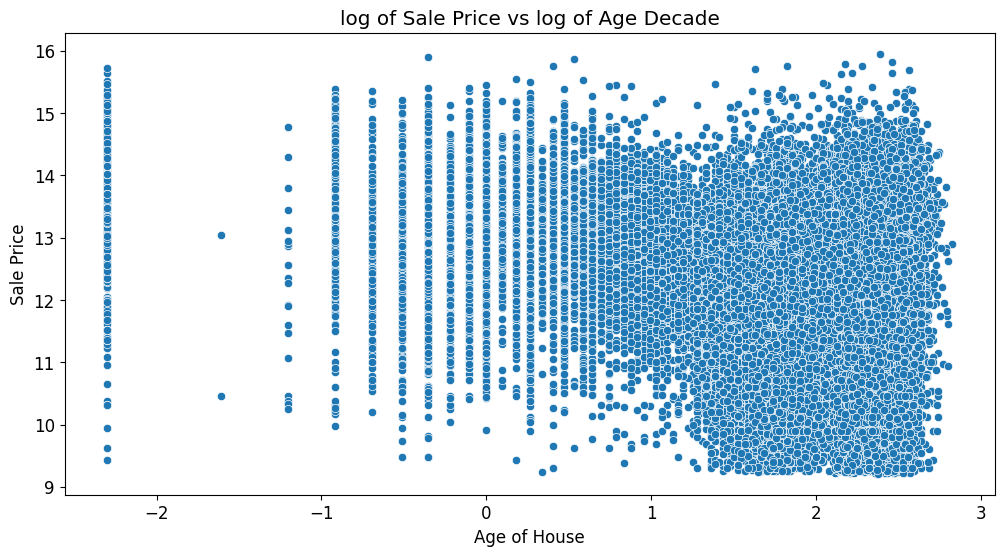

In [312]:
display(training_val_data['Age Decade'].describe())

# visualising the distribution of the age of the houses
plt.figure(figsize=(12, 6))
sns.histplot(training_val_data['Age Decade'], bins=30)
plt.title("Distribution of Age of Houses")
plt.xlabel("Age of House")
plt.ylabel("Frequency")
plt.show()

# finding the correlation between log Age Decade and log Sale Price
log_age_decade = np.log(training_val_data['Age Decade'])
log_sale_price = np.log(training_val_data['Sale Price'])
correlation = log_age_decade.corr(log_sale_price)
print(f"Correlation between log of Age Decade and log of Sale Price: {correlation}")


plt.figure(figsize=(12, 6))
sns.scatterplot(x=np.log(training_val_data[training_val_data['Pure Market Filter'] == 1]['Age Decade']), y=np.log(training_val_data[training_val_data['Pure Market Filter'] == 1]['Sale Price']))
plt.title("log of Sale Price vs log of Age Decade")
plt.xlabel("Age of House")
plt.ylabel("Sale Price")
plt.show()

# Optional code cell for additional work exploring data/ explaining which feature you chose.

In [313]:
display(sum(training_val_data[training_val_data['Pure Market Filter'] == 1]['Estimate (Building)'] == 0))

plt.figure(figsize=(12, 6))
sns.scatterplot(x=training_val_data[training_val_data['Pure Market Filter'] == 1]['Estimate (Building)'], y=np.log(training_val_data[training_val_data['Pure Market Filter'] == 1]['Sale Price']))
plt.title("Log Sale Price vs Estimate (Building)")
plt.xlabel("Estimate (Building)")
plt.ylabel("Log Sale Price")
plt.show()


print("Correlation between Estimate (Building) and Sale Price: ", training_val_data['Estimate (Building)'].corr(training_val_data['Sale Price']))

1235

Correlation between Estimate (Building) and Sale Price:  0.6092859158684686


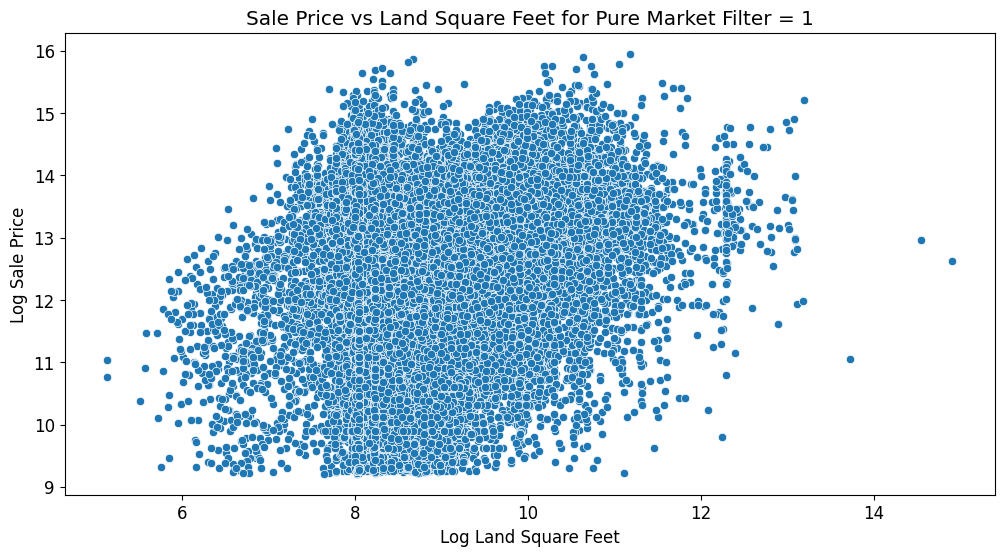

Correlation between log of Land Square Feet and log of Sale Price: 0.2578511813965192


In [314]:
# scatter plot land square feet vs sale price

plt.figure(figsize=(12, 6))
filtered_data = training_val_data[training_val_data['Pure Market Filter'] == 1]
sns.scatterplot(x=np.log(filtered_data['Land Square Feet']), y=np.log(filtered_data['Sale Price']))
plt.title("Sale Price vs Land Square Feet for Pure Market Filter = 1")
plt.xlabel("Log Land Square Feet")
plt.ylabel("Log Sale Price")
plt.show()

# finding correlation

log_land_sqft = np.log(filtered_data['Land Square Feet'])
correlation = log_land_sqft.corr(log_sale_price)
print(f"Correlation between log of Land Square Feet and log of Sale Price: {correlation}")



<!-- END QUESTION -->

### Question 5b:  Create Model 3

In the cells below fill in the code to create and analyze Model 3 (follow the Modeling steps outlined in Questions 3 and 4).

PLEASE DO NOT ADD ANY ADDITIONAL CELLS IN THIS PROBLEM OR IT MIGHT MAKE THE AUTOGRADER FAIL

<!-- BEGIN QUESTION -->



In [315]:
# Modeling Step 1:  Process the Data

# Hint: You can either use your implementation of the One Hot Encoding Function 
#from Project Part 1, or use the staff's implementation

from feature_func import *


# Optional:  Define any helper functions you need for one-hot encoding above this line


def process_data_m3(data):
    
    # You should start by only keeping values with Pure Market Filter = 1
    
    # Remove Non-Market Sales
    data = data[data["Pure Market Filter"]==1]

    # Create Log Sale Price column
    data["Log Sale Price"] = np.log(data["Sale Price"])

    # Create Log Building Square Feet column
    data["Log Building Square Feet"] = np.log(data["Building Square Feet"])

    # Create Log Estimate (Building) column
    data["Log Estimate (Building)"] = np.log(data["Estimate (Building)"] + 1)

    # Change Roof Material to names
    data = substitute_roof_material(data)

    # one-hot encode the roof material
    data = ohe_roof_material(data)

    # select only relevant columns
    relevant_columns = ['Log Estimate (Building)', 'Log Building Square Feet', 'Log Sale Price'] + [col for col in data.columns if "Roof Material_" in col]
    data = data[relevant_columns]


    
    return data

    
# Use the same original train and valid datasets from 3a 
#(otherwise the validation errors aren't comparable), 
# Don't resplit the data.  


# Process the data for Model 3
processed_train_m3 = process_data_m3(train)

processed_val_m3 = process_data_m3(valid)

# Create X (Dataframe) and Y (series) to use to train the model
X_train_m3 = processed_train_m3.drop(columns = ["Log Sale Price"])
Y_train_m3 = processed_train_m3["Log Sale Price"]

X_valid_m3 = processed_val_m3.drop(columns = ["Log Sale Price"])
Y_valid_m3 = processed_val_m3["Log Sale Price"]


# Take a look at the result
display(X_train_m3.head())
display(Y_train_m3.head())

display(X_valid_m3.head())
display(Y_valid_m3.head())

Log Estimate (Building)  Log Building Square Feet  \
130829                13.019934                  7.870166   
193890                10.969766                  7.002156   
30507                 11.569599                  6.851185   
91308                 12.839685                  7.228388   
131132                12.357553                  7.990915   

        Roof Material_Other  Roof Material_Shake  \
130829                  0.0                  0.0   
193890                  0.0                  0.0   
30507                   0.0                  0.0   
91308                   0.0                  0.0   
131132                  0.0                  0.0   

        Roof Material_Shingle/Asphalt  Roof Material_Slate  \
130829                            1.0                  0.0   
193890                            1.0                  0.0   
30507                             1.0                  0.0   
91308                             1.0                  0.0   
131132                            1.0                  0.0   

        Roof Material_Tar&Gravel  Roof Material_Tile  
130829                       0.0                 0.0  
193890                       0.0                 0.0  
30507                        0.0                 0.0  
91308                        0.0                 0.0  
131132                       0.0                 0.0

130829    12.994530
193890    11.848683
30507     11.813030
91308     13.060488
131132    12.516861
Name: Log Sale Price, dtype: float64

Log Estimate (Building)  Log Building Square Feet  \
50636                 11.669767                  7.310550   
82485                 12.264676                  7.325808   
193966                10.669908                  7.090077   
160612                12.154100                  7.281386   
7028                  11.355581                  7.118016   

        Roof Material_Other  Roof Material_Shake  \
50636                   0.0                  0.0   
82485                   0.0                  0.0   
193966                  0.0                  0.0   
160612                  0.0                  0.0   
7028                    0.0                  0.0   

        Roof Material_Shingle/Asphalt  Roof Material_Slate  \
50636                             1.0                  0.0   
82485                             1.0                  0.0   
193966                            1.0                  0.0   
160612                            1.0                  0.0   
7028                              1.0                  0.0   

        Roof Material_Tar&Gravel  Roof Material_Tile  
50636                        0.0                 0.0  
82485                        0.0                 0.0  
193966                       0.0                 0.0  
160612                       0.0                 0.0  
7028                         0.0                 0.0

50636     11.682668
82485     12.820655
193966     9.825526
160612    12.468437
7028      12.254863
Name: Log Sale Price, dtype: float64

In [316]:
# Modeling STEP 2:  Create a Multiple Linear Regression Model

# Be sure to set fit_intercept to False, since we are incorporating one-hot-encoded data
linear_model_m3 = lm.LinearRegression(fit_intercept=False)

# Fit the model using the processed training data
linear_model_m3.fit(X_train_m3, Y_train_m3)
# your code above this line to create regression model for Model 2

Y_predict_train_m3 = linear_model_m3.predict(X_train_m3)

Y_predict_valid_m3 = linear_model_m3.predict(X_valid_m3)




In [317]:
# MODELING STEP 3:  Evaluate the RMSE for your model

# Training and test errors for the model (in its units of Log Sale Price)

training_error_log[2] = rmse(Y_predict_train_m3, Y_train_m3)
validation_error_log[2]= rmse(Y_predict_valid_m3, Y_valid_m3)

# Training and test errors for the model (in its original values before the log transform)
training_error[2] = rmse(np.exp(Y_predict_train_m3), np.exp(Y_train_m3))
validation_error[2] = rmse(np.exp(Y_predict_valid_m3), np.exp(Y_valid_m3))


(print("3rd Model\nTraining RMSE (log): {}\nValidation RMSE (log): {}\n"
      .format(training_error_log[2], validation_error_log[2]))
)

(print("3rd Model \nTraining RMSE: {}\nValidation RMSE: {}\n"
       .format(training_error[2], validation_error[2]))
)


3rd Model
Training RMSE (log): 0.7240559890113686
Validation RMSE (log): 0.7217962345952899

3rd Model 
Training RMSE: 231705.33504415533
Validation RMSE: 236566.6507003559



In [318]:
# MODELING STEP 4:  Conduct 5-fold cross validation for model and output RMSE

# Create a new model to fit on the whole training_val dataset
linear_model_m3_cv = lm.LinearRegression(fit_intercept=False)

# Process the entire training_val dataset using the pipeline
processed_full_m3 = process_data_m3(training_val_data)

# Split into X and Y:
X_full_m3 = processed_full_m3.drop(columns = "Log Sale Price")
Y_full_m3 = processed_full_m3["Log Sale Price"]

cv_error[2] = cross_validate_rmse(linear_model_m3_cv, X_full_m3, Y_full_m3)

# your code above this line to use 5-fold cross-validation and 
#output RMSE (in units of dollars)

cv_error[2] = cross_validate_rmse(linear_model_m3, X_full_m3, Y_full_m3)

print("3rd Model Cross Validation RMSE: {}".format(cv_error[2]))



3rd Model Cross Validation RMSE: 232477.29879015923


In [319]:
# MODELING STEP 5:  Add a name for your 3rd model describing the features 
#and run this cell to Plot bar graph all 3 models

model_names[2] = "M3: log(bsqft)+log(est_bldg)+Roof"


fig = go.Figure([
go.Bar(x = model_names, y = training_error, name="Training RMSE"),
go.Bar(x = model_names, y = validation_error, name="Validation RMSE"),
go.Bar(x = model_names, y = cv_error, name="Cross Val RMSE")
])

fig.update_yaxes(range=[180000,260000], title="RMSE")

fig


In [320]:
# MODELING STEP 5 cont'd:  Plot 2 side-by-side residual plots 
#(similar to Question 3, for validation data)

fig, ax = plt.subplots(1,2, figsize=(15, 5))


x_plt1 = Y_predict_valid_m3
y_plt1 = Y_valid_m3 - Y_predict_valid_m3

x_plt2 = Y_valid_m3
y_plt2 = Y_valid_m3 - Y_predict_valid_m3


ax[0].scatter(x_plt1, y_plt1, alpha=.25)
ax[0].axhline(0, c='black', linewidth=1)
ax[0].set_xlabel(r'Predicted Log(Sale Price)')
ax[0].set_ylabel(r'Residuals: Log(Sale Price) - Predicted Log(Sale Price)');
ax[0].set_title("Model 3 Val Data: Residuals vs. Predicted Log(Sale Price)")

ax[1].scatter(x_plt2, y_plt2, alpha=.25)
ax[1].axhline(0, c='black', linewidth=1)
ax[1].set_xlabel(r'Log(Sale Price)')
ax[1].set_ylabel(r'Residuals: Log(Sale Price) - Predicted Log(Sale Price)');
ax[1].set_title("Model 3 Val Data: Residuals vs. Log(Sale Price)")


Text(0.5, 1.0, 'Model 3 Val Data: Residuals vs. Log(Sale Price)')

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 5c

i).  Comment on your RMSE and residual plots from Model 3 compared to the first 2 models.  

ii).  Are the residuals of your model still showing a trend that overestimates lower priced houses and underestimates higher priced houses?   If so, how could you try to address this in the next round of modeling?

iii).  If you had more time to improve your model, what would your next steps be?


i) The RMSE of Model 3 is significantly lower than both Models 1 and 2. Comparing the residual plot of Model 3 to Models 1 and 2, we can see that it is much more evenly distributed around 0. It more accurately estimates the sale prices of more expensive properties and does not overestimate lower priced houses as much as the previous models.

ii) The residuals still show a trend of overestimating lower priced houses and underestimating higher priced houses. To address this, we could try to add more features to the model to try capture more patterns within the dataset but this might cause the model to be overfitted. We might have to look at using other machine learning models to capture other patterns that a linear regression model might not be able to capture. Qualitative features like Zip Code cannot be used in linear regressioni models but could be used in other models.

iii) If i have more time, maybe it might be possible to get average estimated market value for each zipcode and using that to scale building square feet to increase its importance for wealthier neighbourhoods. Another thing that might be possible is to check the density of a neighbourhood and use that as a feature.

<!-- END QUESTION -->

<hr style="border: 1px solid #fdb515;" />

## Question 6: Evaluating the Model in Context

<br>

<!-- BEGIN QUESTION -->

---
## Question 6a

When evaluating your model, we used RMSE. In the context of estimating the value of houses, what does the residual mean for an individual homeowner? How does it affect them in terms of property taxes? Discuss the cases where residual is positive and negative separately.

In the context of estimating house values, the residual represents the difference between the actual sale price of a house and the price predicted by our model. For an individual homeowner, this difference can impact their property taxes in different ways depending on the sign of the residual.

When the residual is positive, it means that our model has underestimated the value of a house. For the homeowner, this could result in lower property taxes since the assessed value used for tax calculation is less than the actual market value. It could also mean that the homeowner not know the full value of their property if they decide to sell.

Conversely, a negative residual indicates that our model has overestimated the value of a house. This could lead to higher property taxes for the homeowner, as the assessed value is higher than it should be. This scenario is bad for homeowners especially since our model tends to overestimate lower cost properties. This means the people who can afford it the least are the ones who are paying the most, proportionally, in property taxes.

<!-- END QUESTION -->

In the case of the Cook County Assessor’s Office, Chief Data Officer Rob Ross states that fair property tax rates are contingent on whether property values are assessed accurately - that they’re valued at what they’re worth, relative to properties with similar characteristics. This implies that having a more accurate model results in fairer assessments. The goal of the property assessment process for the CCAO, then, is to be as accurate as possible. 

When the use of algorithms and statistical modeling has real-world consequences, we often refer to the idea of fairness as a measurement of how socially responsible our work is. Fairness is incredibly multifaceted: Is a fair model one that minimizes loss - one that generates accurate results? Is it one that utilizes "unbiased" data? Or is fairness a broader goal that takes historical contexts into account?

These approaches to fairness are not mutually exclusive. If we look beyond error functions and technical measures of accuracy, we'd not only consider _individual_ cases of fairness, but also what fairness - and justice - means to marginalized communities on a broader scale. We'd ask: What does it mean when homes in predominantly Black and Hispanic communities in Cook County are consistently overvalued, resulting in proportionally higher property taxes? When the white neighborhoods in Cook County are consistently undervalued, resulting in proportionally lower property taxes? 

Having "accurate" predictions doesn't necessarily address larger historical trends and inequities, and fairness in property assessments in taxes works beyond the CCAO's valuation model. Disassociating accurate predictions from a fair system is vital to approaching justice at multiple levels. Take Evanston, IL - a suburb in Cook County - as an example of housing equity beyond just improving a property valuation model: Their City Council members [recently approved reparations for African American residents](https://www.usnews.com/news/health-news/articles/2021-03-23/chicago-suburb-approves-government-reparations-for-black-residents).

<!-- BEGIN QUESTION -->

<br>

---

## Question 6b

Reflecting back on your exploration in Questions 5 and 6a, in your own words, what makes a model's predictions of property values for tax assessment purposes "fair"? 

This question is open-ended and part of your answer may depend upon your specific model; we are looking for thoughtfulness and engagement with the material, not correctness. 

**Hint:** Some guiding questions to reflect on as you answer the question above: What is the relationship between RMSE, accuracy, and fairness as you have defined it? Is a model with a low RMSE necessarily accurate? Is a model with a low RMSE necessarily "fair"? Is there any difference between your answers to the previous two questions? And if so, why?

The fairness of a model wouldn't just be based off minimising its RMSE. A fair model should also not make significant amounts of errors and should not be affected by socio-economic status of homeowners and biases of the law.

In this situation we want to make sure that the residual plot is evenly and tightly distributed around 0 as for many, being unfairly taxed can be a huge financial burden.


<!-- END QUESTION -->

<hr style="border: 1px solid #fdb515;" />

## Extra Credit:  How Low Can You Go?   Create Your Own Model and Check RMSE on the Test Data

<br>

---



For **extra credit**, you can create your own model to try to improve the RMSE and residual plots even further. 

The tables below provide scoring guidelines for the extra credit opportunity in this problem. 
If your RMSE lies in a particular range, you will receive the number of points associated with that range.



### Extra Credit Grading Scheme

**Important**: while your Validation RMSE can be checked at any time in this notebook, your Test RMSE can only be checked once by submitting your model’s predictions to Gradescope. The thresholds are as follows:

Extra Credit Points | +10 | +8 | +6  | +4 | + 2
--- | --- | --- | --- | --- | ---
Validation RMSE | Less than 200k | [200k, 210k) | [210k, 220k) | [220k, 230k)  | [230k, 235k)

Extra Credit Points | +10 | +8 | +6  | +4 | + 2
--- | --- | --- | --- | --- | ---
Test RMSE | Less than 200k | [200k, 210k) | [210k, 220k) | [220k, 230k)| [230k, 235k)

<br><br>

To receive these points, you need to show your work in the cells below AND complete the EXPLANATION STEP at the end (explaining what you did to create your model).  

You ALSO MUST UPLOAD your test prediction .csv to the **"Project 2 Extra Credit Test Predictions"** assignment in Gradescope to receive extra credit for your test predictions.

---



## Some notes before you start

- **If you are running into memory issues, restart the kernel and only run the cells you need to.**   If needed you can use the commented cell below (question cell) that contains most to all of the imports necessary to successfully complete this portion of the project, so it can be completed independently code-wise from the remainder of the project, and you do not need to rerun the cell at the top of this notebook. The autograder will have more than 4GB of memory, so you will not lose credit as long as your solution to this question is within the total memory (4GB) limits of DataHub. By default, we reset the memory and clear all variables using `%reset -f`. If you want to delete specific variables, you may also use `del` in place of `%reset -f%`. For example, the following code will free up memory from data used for older models: `del training_val_data, test_data, train, validation, X_train_m1, X_valid_m1, X_train_m2, X_valid_m1`. Our staff solution can be run independently from all other questions, so we encourage you to do the same to make debugging easier.
- Tip: This is a **great time to try using [regularization](https://learningds.org/ch/16/ms_regularization.html)** for model selection. 
- To avoid memory issues, you do not need to include cross validation for this step.  Your score will be based on the Validation Data set RMSE and the Test dataset RMSE.
- **Note: If you need the data again after deleting the variables or resetting, you must reload them again.**
- You will be predicting `Log Sale Price` on the data stored in `cook_county_contest_test.csv`. We will delog/exponentiate your prediction on Gradescope to compute RMSE and use this to score your model. Before submitting to Gradescope, make sure that your predicted values can all be delogged (i.e., if one of your `Log Sale Price` predictions is 60, it is too large; $e^{60}$ is too big!)
- You MUST remove any additional new cells you add before submitting to Gradescope to avoid any autograder errors. 


**PLEASE READ THE ABOVE MESSAGE CAREFULLY!**

**Hints:** 
- Some features may have missing values in the test set but not in the training set (especially if you're one-hot-encoding). Make sure `process_data_ec` handles missing values appropriately for each feature!



In [321]:
neighborhood_density =training_val_data[training_val_data['Pure Market Filter']==1]['Neighborhood Code'].value_counts(normalize=True)
# Optional code cell for additional work exploring data/ explaining which feature you chose.
# You can add additional code cells directly below this if needed.

density_building_square_feet = training_val_data[training_val_data['Pure Market Filter'] == 1]['Building Square Feet'] * training_val_data[training_val_data['Pure Market Filter'] == 1]['Neighborhood Code'].map(neighborhood_density)


#plotting scatter plot of neighborhood density vs log sale price

plt.figure(figsize=(12, 6))
sns.scatterplot(x=np.log(density_building_square_feet), y=np.log(training_val_data['Sale Price']))
plt.title("Sale Price vs Log(Neighborhood Density * Building Square Feet)")
plt.xlabel("Log(Neighborhood Density * Building Square Feet)")
plt.ylabel("Log Sale Price")
plt.show()

# finding correlation
correlation = np.log(density_building_square_feet).corr(log_sale_price)
print(f"Correlation between log of Neighborhood Density * Building Square Feet and log of Sale Price: {correlation}")

Correlation between log of Neighborhood Density * Building Square Feet and log of Sale Price: 0.2809509522107557


In [322]:
# get the average Estimate (Building) for each neighborhood
avg_estimate_building = training_val_data[training_val_data['Pure Market Filter'] == 1].groupby('Neighborhood Code')['Estimate (Building)'].mean()

display(avg_estimate_building)

# multiply the average estimate building by density_building_square_feet
estimate_building_density = density_building_square_feet * training_val_data['Neighborhood Code'].map(avg_estimate_building)

#plotting scatter plot of estimate building density vs log sale price
plt.figure(figsize=(12, 6))
sns.scatterplot(x=np.log(estimate_building_density), y=np.log(training_val_data['Sale Price']))
plt.title("Sale Price vs $\log{Estimate Building Density}$")
plt.xlabel("Log(Estimate Building Density)")
plt.ylabel("Log Sale Price")
plt.show()

# finding correlation
correlation = np.log(estimate_building_density).corr(log_sale_price)
print(f"Correlation between log of Estimate Building Density and log of Sale Price: {correlation}")
# Optional code cell for additional work exploring data/ explaining which feature you chose.

Neighborhood Code
10     202301.070117
11     257439.725191
12     390389.159916
13     230422.717498
14     286207.200000
           ...      
463    338636.470588
520    145727.250000
560    271540.846154
580    578333.000000
600    330970.000000
Name: Estimate (Building), Length: 193, dtype: float64

Correlation between log of Estimate Building Density and log of Sale Price: 0.38296484626029714


In [323]:
training_val_data['Property Class'].value_counts().sort_index()

202    33571
203    94359
204    12369
205    19855
206     7990
207     8115
208     2972
209     1311
278    24250
Name: Property Class, dtype: int64

In [324]:
#Optional cell to try if you're having memory issues (i.e. if kernel keeps dying)


# If you're having memory issues, uncomment the lines below to clean up 
#memory from previous questions and reinitialize Otter!



# MAKE SURE TO RECOMMENT THE NEXT 3 LINES OUT BEFORE SUBMITTING!

#%reset -f
#import otter
#grader = otter.Notebook("ProjPart2.ipynb")


#import numpy as np
#import pandas as pd
#from pandas.api.types import CategoricalDtype

#%matplotlib inline
#import matplotlib.pyplot as plt
#import seaborn as sns
#from sklearn import linear_model as lm

#import warnings
#warnings.filterwarnings("ignore")

#import zipfile
#import os

#import plotly.graph_objects as go

#from ds100_utils import *
#from feature_func import *




#training_val_data = pd.read_csv("cook_county_train_val.csv", index_col='Unnamed: 0')
#test_data = pd.read_csv("cook_county_contest_test.csv", index_col='Unnamed: 0')

# COPY THESE FUNCTIONS FROM ABOVE

#def rmse(predicted, actual):
    


#def train_val_split(data):
    
    

## This makes the train-test split in this section reproducible across different runs of the notebook. DO NOT CHANGE THIS RANDOM SEED.
#np.random.seed(1337)

#train, valid = train_val_split(training_val_data)


<!-- BEGIN QUESTION -->

## Extra Credit Step 1: Creating Your Model
Complete the modeling steps (you can skip the cross validation step to save memory) in the cells below.

DO NOT ADD ANY EXTRA CELLS BELOW (for this part of the problem)

In [325]:
# Modeling Step 1:  Process the Data




# Hint: You can either use your implementation of the One Hot Encoding Function from 
#Project Part 1, or use the staff's implementation
from feature_func import *
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso


# Optional:  Define any helper functions you need (for example, for one-hot 
#encoding, etc) above this line


def process_data_ec(data, is_test_set=False):
    # Please include all of your feature engineering processes for both 
    #the training/validation as well as the test data inside this function.  
    
    # Can include feature engineering processes for both the training/validation 
    # and the test data above this line
    
    
    # Whenever you access 'Log Sale Price' or 'Sale Price', make sure to use the
    # condition is_test_set like this:
    if not is_test_set:
        # Processing for the training/validation set (i.e. not the test set)
        # CAN involve references to sale price!
        # CAN involve filtering certain rows or removing outliers
        
        # Q1 = data["Sale Price"].quantile(0.25)
        # Q3 = data["Sale Price"].quantile(0.75)
        # IQR = Q3 - Q1
        # upper_limit = Q3 + 2.5 * IQR
        data = data[(data["Pure Market Filter"]==1) & (data["Sale Price"] >= 100) ]
        # Create Log Sale Price column
        data["Log Sale Price"] = np.log(data["Sale Price"])

        # # Get density of each zip code
        # neighborhood_density = data['Neighborhood Code'].value_counts(normalize=True)

        # # Create density_building_square_feet
        # density_building_square_feet = data['Building Square Feet'] * data['Neighborhood Code'].map(neighborhood_density)

        # # Create Estimate Building Density
        # avg_estimate_building = data.groupby('Neighborhood Code')['Estimate (Building)'].mean()

        # estimate_building_density = density_building_square_feet * data['Neighborhood Code'].map(avg_estimate_building)

        # # Create Log Estimate Building Density
        # data['Log Estimate Building Density'] = np.log(estimate_building_density)

        relevant_columns = [ 'Log Sale Price']
    

        # Include the rest of your feature engineering processes for the 
        #training/validation set above this line
        
    else:
        # Processing for the test set
        # CANNOT involve references to sale price!
        # CANNOT involve removing any rows
        
        # # Get density of each zip code
        # neighborhood_density = data['Neighborhood Code'].value_counts(normalize=True)

        # # Create density_building_square_feet
        # density_building_square_feet = data['Building Square Feet'] * data['Neighborhood Code'].map(neighborhood_density)

        # # Create Estimate Building Density
        # avg_estimate_building = data.groupby('Neighborhood Code')['Estimate (Building)'].mean()

        # estimate_building_density = density_building_square_feet * data['Neighborhood Code'].map(avg_estimate_building)

        # Create Log Estimate Building Density
        # data['Log Estimate Building Density'] = np.log(estimate_building_density)

        relevant_columns = []

    scaler = StandardScaler()
    data['Standardized Age'] = scaler.fit_transform(data[['Age']])

    # Create Log Building Square Feet column
    data["Log Building Square Feet"] = np.log(data["Building Square Feet"] + 1)

    # Create Log Estimate (Building) column
    data["Log Estimate (Building)"] = np.log(data["Estimate (Building)"] +1)

    # Create Log Estimate (Land) column
    data["Log Estimate (Land)"] = np.log(data["Estimate (Land)"] + 1)
    # Add any remaining processing for both test and training set below 
    #(hint - easiest to put any calls to your One Hot Encoding function here):
    
    # one hot encoding for property class
    property_classes = [200, 202, 203, 204, 205, 206, 207, 208, 209, 278, 234, 295]
    for pc in property_classes:
        data[f'Property_Class_{pc}'] = (data['Property Class'] == pc).astype(int)

    relevant_columns = relevant_columns + ['Log Building Square Feet', 'Log Estimate (Building)', 'Standardized Age', 'Log Estimate (Land)']
    relevant_columns += [f'Property_Class_{pc}' for pc in property_classes]


    data = data[relevant_columns]
    return data


# Use the same original train and valid datasets from 3a (otherwise the 
# validation errors aren't comparable).  Don't resplit the data.  
    
# Process the data 
processed_train_ec = process_data_ec(train)

processed_val_ec = process_data_ec(valid)


X_train_ec = processed_train_ec.drop(columns = ["Log Sale Price"])
Y_train_ec = processed_train_ec["Log Sale Price"]

X_valid_ec = processed_val_ec.drop(columns = ["Log Sale Price"])
Y_valid_ec = processed_val_ec["Log Sale Price"]

# Take a look at the result
display(X_train_ec.head())
display(Y_train_ec.head())

display(X_valid_ec.head())
display(Y_valid_ec.head())



Log Building Square Feet  Log Estimate (Building)  Standardized Age  \
130829                  7.870548                13.019934         -1.308199   
193890                  7.003065                10.969766          1.061552   
30507                   6.852243                11.569599         -0.158173   
91308                   7.229114                12.839685         -1.377898   
131132                  7.991254                12.357553         -1.203651   

        Log Estimate (Land)  Property_Class_200  Property_Class_202  \
130829            10.619643                   0                   0   
193890            10.043293                   0                   0   
30507             10.671301                   0                   1   
91308             10.940242                   0                   0   
131132            11.006440                   0                   0   

        Property_Class_203  Property_Class_204  Property_Class_205  \
130829                   0                   0                   0   
193890                   1                   0                   0   
30507                    0                   0                   0   
91308                    0                   0                   0   
131132                   0                   0                   0   

        Property_Class_206  Property_Class_207  Property_Class_208  \
130829                   0                   0                   0   
193890                   0                   0                   0   
30507                    0                   0                   0   
91308                    0                   1                   0   
131132                   0                   0                   0   

        Property_Class_209  Property_Class_278  Property_Class_234  \
130829                   0                   1                   0   
193890                   0                   0                   0   
30507                    0                   0                   0   
91308                    0                   0                   0   
131132                   0                   1                   0   

        Property_Class_295  
130829                   0  
193890                   0  
30507                    0  
91308                    0  
131132                   0

130829    12.994530
193890    11.848683
30507     11.813030
91308     13.060488
131132    12.516861
Name: Log Sale Price, dtype: float64

Log Building Square Feet  Log Estimate (Building)  Standardized Age  \
50636                   7.311218                11.669767          1.842927   
82485                   7.326466                12.264676          0.474693   
193966                  7.090910                10.669908         -0.156799   
160612                  7.282074                12.154100         -0.016468   
7028                    7.118826                11.355581          1.000937   

        Log Estimate (Land)  Property_Class_200  Property_Class_202  \
50636             10.937579                   0                   0   
82485             10.649251                   0                   0   
193966             9.932609                   0                   0   
160612            10.560774                   0                   0   
7028              10.472799                   0                   0   

        Property_Class_203  Property_Class_204  Property_Class_205  \
50636                    1                   0                   0   
82485                    0                   0                   1   
193966                   1                   0                   0   
160612                   1                   0                   0   
7028                     1                   0                   0   

        Property_Class_206  Property_Class_207  Property_Class_208  \
50636                    0                   0                   0   
82485                    0                   0                   0   
193966                   0                   0                   0   
160612                   0                   0                   0   
7028                     0                   0                   0   

        Property_Class_209  Property_Class_278  Property_Class_234  \
50636                    0                   0                   0   
82485                    0                   0                   0   
193966                   0                   0                   0   
160612                   0                   0                   0   
7028                     0                   0                   0   

        Property_Class_295  
50636                    0  
82485                    0  
193966                   0  
160612                   0  
7028                     0

50636     11.682668
82485     12.820655
193966     9.825526
160612    12.468437
7028      12.254863
Name: Log Sale Price, dtype: float64

In [326]:
# Modeling STEP 2:  Create a Multiple Linear Regression Model

# If you are are incorporating one-hot-encoded data, set the fit_intercept to False

linear_model_ec = lm.LinearRegression(fit_intercept=False)

linear_model_ec.fit(X_train_ec, Y_train_ec)

# your code above this line to create regression model for Model 2

Y_predict_train_ec = linear_model_ec.predict(X_train_ec)

Y_predict_valid_ec = linear_model_ec.predict(X_valid_ec)




In [327]:
# MODELING STEP 3:  Evaluate the RMSE for your model


# Training and test errors for the model 
#(in its original values before the log transform)

training_error_ec = rmse(np.exp(Y_predict_train_ec), np.exp(Y_train_ec))
validation_error_ec = rmse(np.exp(Y_predict_valid_ec), np.exp(Y_valid_ec))


(print("Extra Credit \nTraining RMSE: {}\nValidation RMSE: {}\n"
       .format(training_error_ec, validation_error_ec))
)


Extra Credit 
Training RMSE: 207040.79633981557
Validation RMSE: 206919.13392923432



In [328]:
# Optional: Run this cell to visualize

import plotly.graph_objects as go

fig = go.Figure([
go.Bar(x = ["Extra Credit Model"], y = [training_error_ec], name="Training RMSE"),
go.Bar(x = ["Extra Credit Model"], y = [validation_error_ec], name="Validation RMSE"),

])


fig
fig.update_yaxes(range=[140000,260000], title="RMSE")
# Feel free to update the range as needed

Text(0.5, 1.0, 'EC Val Data: Residuals vs. Log(Sale Price)')

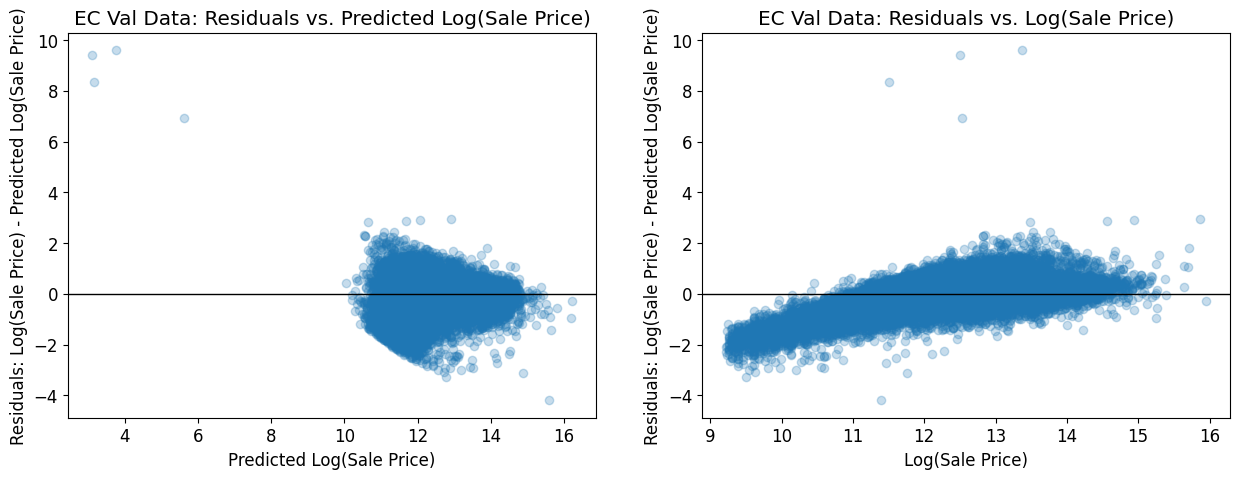

In [329]:
# MODELING STEP 5: Plot 2 side-by-side residual plots for validation data

fig, ax = plt.subplots(1,2, figsize=(15, 5))


x_plt1 = Y_predict_valid_ec
y_plt1 = Y_valid_ec - Y_predict_valid_ec

x_plt2 = Y_valid_ec
y_plt2 = Y_valid_ec - Y_predict_valid_ec


ax[0].scatter(x_plt1, y_plt1, alpha=.25)
ax[0].axhline(0, c='black', linewidth=1)
ax[0].set_xlabel(r'Predicted Log(Sale Price)')
ax[0].set_ylabel(r'Residuals: Log(Sale Price) - Predicted Log(Sale Price)');
ax[0].set_title("EC Val Data: Residuals vs. Predicted Log(Sale Price)")

ax[1].scatter(x_plt2, y_plt2, alpha=.25)
ax[1].axhline(0, c='black', linewidth=1)
ax[1].set_xlabel(r'Log(Sale Price)')
ax[1].set_ylabel(r'Residuals: Log(Sale Price) - Predicted Log(Sale Price)');
ax[1].set_title("EC Val Data: Residuals vs. Log(Sale Price)")


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

## Extra Credit Step 2:  Explanation (Required for points on model above):

Explain what you did to create your model.  What versions did you try?  What worked and what didn't? 

Comment on the RMSE and residual plots from your model.   Are the residuals of your model still showing a trend that overestimates lower priced houses and underestimates higher priced houses? 


For my model I tried taking the average of the estimated market value for each zipcode and used that to scale the building square feet. This was to increase the importance of square footage in densely populated neighborhoods especially the wealthier ones. But because I did not really get good results with that I decided to ditch it. It gave a promising correlation to sale price but ultimately was not a good predictor.



My model still shows the same trend of overestimating lower priced houses and underestimating higher priced houses. It might be that the data does not include enough metrics that can capture the nuances of property prices such as crime rates of the area, stigma, etc. 

<!-- END QUESTION -->

## Extra Credit Step 3: Create and Submit Test Set Predictions to Gradescope

Now it's time to test your model on the actual test set.  You are only allowed to submit to Gradescope once, so wait until you have the best version of your model.    

The test data is in the dataframe `test_data`.  

Process the test data and run it through your model. Store your predictions from the test_data in the variable `Y_test_pred`.  These should be in units Log Sale Price (you do not need to exponentiate them).  

Then run the cell provided below to create a .csv file to store your predictions on the test set and submit this .csv to the Gradescope Assignment: **"Project 2 Extra Credit Test Predictions"**. 
Note that **you will not receive credit for the test set predictions (i.e. up to 10 points) unless you submit your.csv to the Gradescope assignment**!


In [330]:
# Cells to process the test_data and run the model on it.  
# You CAN add any additional cells below
# Note: Make sure you don't remove any of the rows from the test data set.

processed_test_ec = process_data_ec(test_data, is_test_set = True) 


Y_test_pred = linear_model_ec.predict(processed_test_ec)

In [331]:
Y_test_pred

array([14.26803136, 11.4493608 , 12.60458362, ..., 12.21264262,
       13.77722606, 13.26467819])

In [332]:
# Run this file to create the .csv of your predictions for the test set to upload to the assignment in Gradescope labeled Project 2 Extra Credit Test Predictions to have it checked.

from datetime import datetime

#Store your predictions for the test set in Y_test_pred 
#(these should be in units of Log Sale Price)


# Construct and save the submission:
submission_df = pd.DataFrame({
    "Id": pd.read_csv('cook_county_contest_test.csv')['Unnamed: 0'], 
    "Value": Y_test_pred,
}, columns=['Id', 'Value'])
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
submission_df.to_csv("submission_{}.csv".format(timestamp), index=False)

print('Created a CSV file: {}.'.format("submission_{}.csv".format(timestamp)))
print('You MUST now upload this CSV file to the Gradescope assignment "Project 2 Extra Credit Test Predictions" for scoring.')

Created a CSV file: submission_20240425_214556.csv.
You MUST now upload this CSV file to the Gradescope assignment "Project 2 Extra Credit Test Predictions" for scoring.


## Congratulations! You have finished the Project - Part 2


If you discussed this assignment with any other students in the class (in a manner that is acceptable as described by the Collaboration policy above) please **include their names** here:

**Collaborators**: *list collaborators here*

### Submission Instructions

Before proceeding any further, **save this notebook.**

After running the `grader.export()` cell provided below, **2 files will be created**: a zip file and pdf file.  You can download them using the links provided below OR by finding them in the same folder where this juptyer notebook resides in your JuptyerHub.

To receive credit on this assignment, **you must submit BOTH of these files
to their respective Gradescope portals:** 

* **Project Part 2 Autograded**: Submit the zip file that is output by the `grader.export()` cell below to the Autograded assignment in Gradescope.

* **Project Part 2 Manually Graded**: Submit your ProjectPart2.PDF to the  Manually Graded assignment in Gradescope.  **YOU MUST SELECT THE PAGES CORRESPONDING TO EACH QUESTION WHEN YOU UPLOAD TO GRADESCOPE.  IF NOT, YOU WILL LOSE POINTS**   Also, **check** that all of your plots **and** all lines of your code are showing up in your PDF before submitting.  If not, you will not receive credit for your plots/code.  

* **Extra Credit Submission**:  If you completed the extra credit, to receive credit for the Test Case prediction you must submit your Test Case prediction.csv (generated in the last cell of the extra credit section) to the Gradescope assignment titled "Project 2 Extra Credit Test Predictions"

**You are responsible for ensuring your submission follows our requirements. We will not be granting regrade requests nor extensions to submissions that don't follow instructions.** If you encounter any difficulties with submission, please don't hesitate to reach out to staff prior to the deadline.

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

AFTER running the cell below, click on <a href='ProjPart2.pdf' download>this link to download the PDF </a> to upload to Gradescope.  There will be a separate link that appears after running the cell below with a link to download the zip file to upload to Gradescope.

In [333]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)

Running your submission against local test cases...


Your submission received the following results when run against available test cases:

    q1c results: All test cases passed!

    q2d results: All test cases passed!

    q3a results: All test cases passed!

    q3b results: All test cases passed!

    q3c results: All test cases passed!

    q3d results: All test cases passed!

    q3e results: All test cases passed!

    q3f results: All test cases passed!

    q4a results: All test cases passed!

    q4b results: All test cases passed!
